In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras import models
from keras.layers import Dropout, MaxPool2D, AveragePooling2D
# from keras.optimizers import RMSProp,Adam
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, LSTM, merge
# from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
import csv
from PIL import Image    
from sklearn.model_selection import train_test_split
from keras.layers import Input, Add, Activation, ZeroPadding2D, BatchNormalization, GlobalMaxPooling2D
from tqdm import tqdm
import numpy as np # linear algebra
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
import collections
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dropout

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# !pip install pandarallel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# path = '/content/drive/MyDrive/'
path = '/content/drive/MyDrive/'


os.listdir(path)

In [ ]:
data = pd.read_csv(path+'icml_face_data.csv')

In [ ]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label
# use pandarallel
def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
 
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
 
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [ ]:
# Train_Data_gen = ImageDataGenerator(
#         featurewise_center = True,
#         featurewise_std_normalization = True)
#         # validation_split = 0.2) 
#         #, rescale = 1./255 (to check whether needed or not )

# data =  Train_generator = Train_Data_gen.flow_from_directory(
#                   location,
#                   target_size=(48,48),
#                   batch_size = 32,
#                   color_mode = "grayscale",
#                   class_mode = "categorical")

# for num_batch_size in len(Train_generator):   # num_batch_size - means the number of batch being trained
#     for num_img_in_batch in len(num_batch_size):   # 
      
#         train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
#         val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
#         test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

#         # TO THINK PART  ...




In [ ]:
data[' Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name:  Usage, dtype: int64

In [ ]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [ ]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [ ]:
train_image_array.shape
train_image_label.shape

(28709,)

In [ ]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
# train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
# val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
# test_images = test_images.astype('float32')/255

In [ ]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

print(np.shape(train_labels))

(28709, 7)


(3589, 48, 48, 1)
(28709, 7)


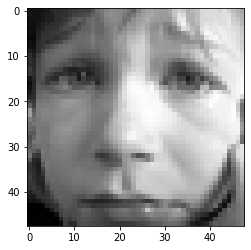

In [ ]:
import cv2
print(np.shape(test_images))
print(np.shape(train_labels))
poo=np.array(train_images[6][:,:,0])
 
np.resize(poo,(48,48))
# poo = cv2.cvtColor(poo, cv2.COLOR_BGR2GRAY)
# print(poo)
 
# del data
plt.imshow(poo,cmap='gray')

In [ ]:
import cv2
import numpy as np
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/drive/My Drive/shape_predictor_68_face_landmarks.dat")

In [ ]:
train_final=[]
detected=[]
for q in range(28709):
  
  gray=np.array(train_images[q][:,:,:],dtype=np.uint8)
  gray=cv2.resize(gray,(48,48))
  faces=detector(gray,1)

  if (np.shape(faces)[0]==0):
    
    continue
  detected.append(q)
  for face in faces:
    x1=face.left()
    y1=face.top()
    x2=face.right()
    y2=face.bottom()
 
    landmarks=predictor(gray, face)
    xlist=[]
    ylist=[]
    for n in range(0,68):
      xlist.append(float(landmarks.part(n).x))
      ylist.append(float(landmarks.part(n).y))

    xmean=np.mean(xlist)
    ymean=np.mean(ylist)
    xcentral=[(x-xmean) for x in xlist] 
    ycentral=[(y-ymean) for y in ylist]
    train_landmark=[]

    for i,j in zip(xcentral,ycentral):

      train_landmark.append([[i],[j]])

    train_final.append(train_landmark)
  

# print(np.shape(train_landmark))
print(np.shape(train_final))
print(np.shape(detected))
# print((train_landmark))
# print((train_final))

(19984, 68, 2, 1)
(19984,)


In [ ]:
train_final, final_train_labels = train_final, train_labels[detected]

In [ ]:
val_final=[]
detected=[]
for q in range(3589):
 
  gray=np.array(val_images[q][:,:,:],dtype=np.uint8)
  gray=cv2.resize(gray,(48,48))
  faces=detector(gray,1)

  if (np.shape(faces)[0]==0):
    
    continue
  detected.append(q)
  for face in faces:
    x1=face.left()
    y1=face.top()
    x2=face.right()
    y2=face.bottom()
 
    landmarks=predictor(gray, face)
    xlist=[]
    ylist=[]
    for n in range(0,68):
      xlist.append(float(landmarks.part(n).x))
      ylist.append(float(landmarks.part(n).y))

    xmean=np.mean(xlist)
    ymean=np.mean(ylist)
    xcentral=[(x-xmean) for x in xlist] 
    ycentral=[(y-ymean) for y in ylist]
    train_landmark=[]

    for i,j in zip(xcentral,ycentral):

      train_landmark.append([[i],[j]])

    val_final.append(train_landmark)
  
 
# print(np.shape(train_landmark))
# print(np.shape(train_final))
 
# print((train_landmark))
# print((train_final))

In [ ]:
final_val_images, final_val_labels = val_images[detected],val_labels[detected]

In [ ]:
# val_labels_final=[]

# for i in range(28709):
#   if i in not_detected:
#     continue

#   else:
#     val_labels_final.append(val_labels[i,:])

# print(np.shape(val_labels_final))

In [ ]:
test_final=[]
detected=[]
for q in range(3589):
 
  gray=np.array(test_images[q][:,:,:],dtype=np.uint8)
  gray=cv2.resize(gray,(48,48))
  faces=detector(gray,1)

  if (np.shape(faces)[0]==0):
    
    continue
  detected.append(q)
  for face in faces:
    x1=face.left()
    y1=face.top()
    x2=face.right()
    y2=face.bottom()
 
    landmarks=predictor(gray, face)
    xlist=[]
    ylist=[]
    for n in range(0,68):
      xlist.append(float(landmarks.part(n).x))
      ylist.append(float(landmarks.part(n).y))

    xmean=np.mean(xlist)
    ymean=np.mean(ylist)
    xcentral=[(x-xmean) for x in xlist] 
    ycentral=[(y-ymean) for y in ylist]
    train_landmark=[]

    for i,j in zip(xcentral,ycentral):

      train_landmark.append([[i],[j]])

    test_final.append(train_landmark)
  
 
# print(np.shape(train_landmark))
# print(np.shape(train_final))
 
# print((train_landmark))
# print((train_final))

In [ ]:
final_test_images, final_test_lables = test_images[detected], test_labels[detected]

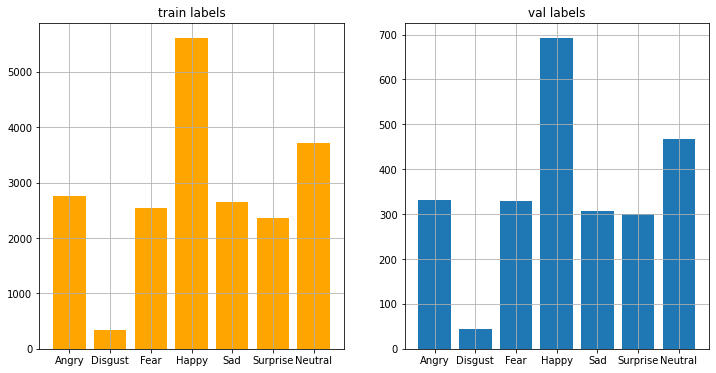

In [ ]:
plot_compare_distributions(final_train_labels, final_val_labels, title1='train labels', title2='val labels')

In [ ]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [ ]:
from keras.layers import Dense, PReLU, LeakyReLU
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow.keras import optimizers
from keras.regularizers import l2

In [ ]:
train_final=np.array(train_final)
final_train_labels=np.array(final_train_labels)
val_final=np.array(val_final)
final_val_labels=np.array(final_val_labels)
final_test_images = np.array(final_test_images)
final_test_lables = np.array(final_test_lables)

print(np.shape(train_final))
print(np.shape(final_train_labels))
print(np.shape(val_final))
print(np.shape(final_val_labels))

# train_final=tuple(train_final)
# final_train_labels=tuple(final_train_labels)
# val_final=tuple(val_final)
# final_val_labels=tuple(final_val_labels)

# print(train_final.shape)
# np.reshape(train_final, (19984, 68, 2))
# np.reshape(val_final, (2471, 68, 2))
# np.reshape(final_train_labels, (19984, 7))
# np.reshape(final_val_labels, (2471, 7))
# print(len(train_final))
# print(val_final.shape)
# print(final_train_labels.shape)
# print(final_val_labels.shape)
# train_final = tuple(train_final)
# final_train_labels = tuple(final_train_labels)
# val_final = tuple(val_final)
# final_val_labels = tuple(final_val_labels)

(19984, 68, 2, 1)
(19984, 7)
(2471, 68, 2, 1)
(2471, 7)


In [ ]:
# shape_of_Landmarks = (68,2)
# model = Sequential()
# model.add(Dense(200, input_shape = shape_of_Landmarks, kernel_regularizer = l2(0.01), bias_regularizer = l2(0.01)))
# model.add(PReLU(alpha_initializer = 'zeros'))
# model.add(Dense(20, use_bias = True))
# model.add(LeakyReLU(alpha = 0.3))
# model.add(Dense(7, activation = "softmax"))
# # model.build(input_shape=shape_of_Landmarks)


In [ ]:
cnn =Sequential()

cnn.add(Conv2D(filters=128, kernel_size=(1,1), activation='relu' ,input_shape=(68 ,2 ,1)))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2,2) ,padding='same'))

cnn.add(Conv2D(filters=128, kernel_size=(1,1), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(filters=256, kernel_size=(1,1), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2,2) ,padding='same'))

cnn.add(Conv2D(filters=256, kernel_size=(1,1), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(filters=256, kernel_size=(1,1), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2,2) ,padding='same'))

cnn.add(Conv2D(filters=256, kernel_size=(1,1), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(filters=128, kernel_size=(1,1), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPool2D(pool_size=(2,2) ,padding='same'))

cnn.add(Conv2D(filters=64, kernel_size=(1,1), activation='relu'))
cnn.add(BatchNormalization())

cnn.add(Flatten())
cnn.add(Dense(7, activation='softmax'))
# cnn.add(BatchNormalization())
# cnn.add(Dense(7 ,Activation=None))

cnn.compile(optimizer='adam' ,loss='squared_hinge' ,metrics=['accuracy'])

# cnn.compile(loss='sparse_categorical_crossentropy',
#                   optimizer=optimizers.RMSprop(learning_rate=2e-4),  # change it to adagrad (lr = 0.001, initial_accumulator_valur = 0.1, epsilon = 1e-07)
#                   metrics=['accuracy'])

In [ ]:
 r=cnn.fit(train_final,final_train_labels, validation_data=(val_final, final_val_labels),epochs=30)

Epoch 1/30
625/625 [==============================] - 38s 12ms/step - loss: 1.1388 - accuracy: 0.4416 - val_loss: 1.1319 - val_accuracy: 0.4743
Epoch 2/30
625/625 [==============================] - 6s 10ms/step - loss: 1.1218 - accuracy: 0.4769 - val_loss: 1.1218 - val_accuracy: 0.4686
Epoch 3/30
625/625 [==============================] - 6s 10ms/step - loss: 1.1170 - accuracy: 0.4857 - val_loss: 1.1173 - val_accuracy: 0.4913
Epoch 4/30
625/625 [==============================] - 6s 10ms/step - loss: 1.1134 - accuracy: 0.4959 - val_loss: 1.1236 - val_accuracy: 0.4763
Epoch 5/30
625/625 [==============================] - 6s 10ms/step - loss: 1.1109 - accuracy: 0.5023 - val_loss: 1.1350 - val_accuracy: 0.4504
Epoch 6/30
625/625 [==============================] - 7s 11ms/step - loss: 1.1090 - accuracy: 0.5063 - val_loss: 1.1105 - val_accuracy: 0.5055
Epoch 7/30
625/625 [==============================] - 6s 10ms/step - loss: 1.1069 - accuracy: 0.5133 - val_loss: 1.1306 - val_accuracy: 0.459

In [ ]:
# cnn.compile(loss='sparse_categorical_crossentropy',
#                   optimizer=optimizers.RMSprop(learning_rate=2e-4),  # change it to adagrad (lr = 0.001, initial_accumulator_valur = 0.1, epsilon = 1e-07)
#                   metrics=['accuracy'])

In [ ]:
# cnn.save('/content/drive/My Drive/challenges-in-representation-learning-facial-expression-recognition-challenge/facial_model.h5')

In [ ]:
train_final.shape
final_train_labels.shape

(19984, 7)

In [ ]:
#np.reshape(final_test_images, (2487, 68, 2, 1))
final_test_images.shape, final_test_lables.shape

((2487, 48, 48, 1), (2487, 7))

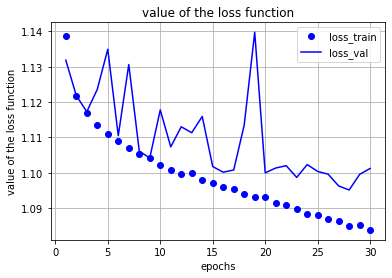

In [ ]:
loss =r.history['loss']
loss_val = r.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

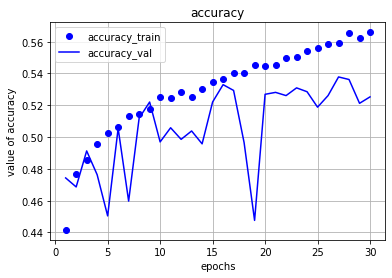

In [ ]:
acc = r.history['accuracy']
acc_val = r.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# test_loss, test_acc = cnn.evaluate(final_test_images, final_test_lables)
# print('test accuracy:', test_acc)

In [ ]:
#cnn.save('results.h5')

In [ ]:
from PIL import Image
print(train_final)
img = tf.keras.preprocessing.image.array_to_img(train_final)
array = tf.keras.preprocessing.image.img_to_array(img)

[array([[ 5.],
       [55.]], dtype=float32), array([[ 0.],
       [95.]], dtype=float32), array([[  0.],
       [129.]], dtype=float32), array([[  5.],
       [169.]], dtype=float32), array([[ 17.],
       [198.]], dtype=float32), array([[ 39.],
       [220.]], dtype=float32), array([[ 68.],
       [243.]], dtype=float32), array([[102.],
       [249.]], dtype=float32), array([[125.],
       [255.]], dtype=float32), array([[147.],
       [249.]], dtype=float32), array([[159.],
       [226.]], dtype=float32), array([[176.],
       [209.]], dtype=float32), array([[187.],
       [186.]], dtype=float32), array([[193.],
       [163.]], dtype=float32), array([[204.],
       [141.]], dtype=float32), array([[210.],
       [118.]], dtype=float32), array([[210.],
       [ 89.]], dtype=float32), array([[62.],
       [50.]], dtype=float32), array([[85.],
       [38.]], dtype=float32), array([[108.],
       [ 38.]], dtype=float32), array([[130.],
       [ 50.]], dtype=float32), array([[153.],
     

In [ ]:
train_final = list(array)
# print(array[0])
pre = array
cnn.predict(pre)

ValueError: ignored